In [571]:
# Generic Libraries
import re
import pandas as pd # For creating dataframes of extracted information
import bs4
import requests
from tqdm import tqdm

# NLP Specific Libraries
import spacy
from spacy import displacy
#nlp=English()
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span
# Libraries for displaying Knowledge Graph

import networkx as nx
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200) 
%matplotlib inline

In [572]:
'''doc= nlp("India is a country in South Asia") 
for tok in doc: 
    print(tok.text, "->", tok.dep_)'''

'doc= nlp("India is a country in South Asia") \nfor tok in doc: \n    print(tok.text, "->", tok.dep_)'

In [573]:
'''sentences_India = ['India is known as Bharat',
             'India is a country in South Asia',
             'India is the seventh-largest country',
             'India is a democratic country',
             'India has its President as Ram Nath Kovind',
             'India has Prime Minister as Narendra Modi'
            ]
sentences_India[1]'''

"sentences_India = ['India is known as Bharat',\n             'India is a country in South Asia',\n             'India is the seventh-largest country',\n             'India is a democratic country',\n             'India has its President as Ram Nath Kovind',\n             'India has Prime Minister as Narendra Modi'\n            ]\nsentences_India[1]"

In [574]:
'''India_df = pd.DataFrame(sentences_India, columns =['India'])'''

"India_df = pd.DataFrame(sentences_India, columns =['India'])"

In [575]:
'''India_df.head(6)'''

'India_df.head(6)'

In [576]:
def get_entities(sent):
  head_entity = ""
  candidate_entity = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  
  for tok in nlp(sent):
    # If token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":

      # CHECK: token is a 'compound' or 'modifier' or 'attribute'
      if tok.dep_ == "compound" or tok.dep_.endswith("mod") or tok.dep_ == "attr":
        prefix = tok.text
        
        # If the previous word was also a 'compound' or 'modifier' or 'attribute', then add the current word to it
        if prv_tok_dep == "compound" or prv_tok_dep.endswith("mod") or prv_tok_dep == "attr":
          prefix = prv_tok_text + " " + tok.text
      
      # Assign head entity or, subject
      if tok.dep_.find("subj") == True:
        head_entity = prefix + " " + tok.text
        prefix = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # Assign candidate entity or, object
      if tok.dep_.find("obj") == True:
        candidate_entity = prefix + " " + tok.text
      else:
        candidate_entity = prefix # In some cases the candidate entity is an 'attribute'
        
      # Update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [head_entity.strip(), candidate_entity.strip()]

In [577]:
'''get_entities("Christiano Ronaldo scored 3 goals")'''

'get_entities("Christiano Ronaldo scored 3 goals")'

In [578]:
'''entity_pairs = []

for i in tqdm(India_df["India"]):
  entity_pairs.append(get_entities(i))'''

'entity_pairs = []\n\nfor i in tqdm(India_df["India"]):\n  entity_pairs.append(get_entities(i))'

In [579]:
'''entity_pairs[0:6]'''

'entity_pairs[0:6]'

In [580]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [581]:
'''relations = [get_relation(i) for i in tqdm(India_df["India"])]'''

'relations = [get_relation(i) for i in tqdm(India_df["India"])]'

In [582]:
'''relations[0:5]'''

'relations[0:5]'

In [583]:
'''source = [i[0] for i in entity_pairs]'''

'source = [i[0] for i in entity_pairs]'

In [584]:
'''target = [i[1] for i in entity_pairs]'''

'target = [i[1] for i in entity_pairs]'

In [585]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,,NATIONALISM,RISE OF
1,,,Introduction
2,,French Nation,Revolution
3,,Europe,Making of
4,,New Middle,Aristocracy


In [586]:
KG_India = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [587]:
'''plt.figure(figsize=(12,12))
pos = nx.spring_layout(KG_India)
nx.draw(KG_India, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()'''

"plt.figure(figsize=(12,12))\npos = nx.spring_layout(KG_India)\nnx.draw(KG_India, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)\nplt.show()"

In [588]:
unstructured_text = pd.read_csv("kg class 10 supplemment sst.csv")
unstructured_text.shape

(18, 3)

In [589]:
unstructured_text['DESCRIPTION'].sample(5)

13    Nationalism in Europe moved away after 1848 and Germany and Italy came to be unified\r\nas nation-states. Prussia took over the leadership of the movement for national unification.\r\nThe architec...
1     Frédéric Sorrieu, a French artist, in 1848 prepared a series of four prints visualising his\r\ndream of a world made up of democratic and Social Republics.\r\nThe first print shows the people of E...
6     In 1815, European governments were driven by a spirit of conservatism.\r\nConservatives believed in monarchy, the Church, social hierarchies, property and\r\nthat the family should be preserved.\r...
5     The term ‘liberalism’ derives from the Latin root liber, meaning free. The right to vote\r\nand to get elected was granted exclusively to property-owning men. Men without\r\nproperty and all women...
8     In July 1830, Bourbon Kings were overthrown by liberal revolutionaries who installed\r\na constitutional monarchy with Louis Philippe at its head. The July Revolution spa

In [590]:
unstructured_text.head(20)

,INDEX,TOPIC,DESCRIPTION
0,0.0,RISE OF NATIONALISM,Chapter name
1,0.1,Introduction,"Frédéric Sorrieu, a French artist, in 1848 prepared a series of four prints visualising his\r\ndream of a world made up of democratic and Social Republics.\r\nThe first print shows the people of E..."
2,1.0,The French Revolution and the Idea of the Nation,In 1789 Nationalism came with French Revolution and the political and constitutional\r\nchanges led to the transfer of sovereignty from the monarchy to a body of French\r\ncitizens. Various measur...
3,2.0,The Making of Nationalism in Europe,"Germany, Italy and Switzerland were divided into kingdoms, duchies and cantons whose rulers had their autonomous territories."
4,2.1,The Aristocracy and the New Middle Class,The Aristocracy was the dominant class on the continent politically and socially. The\r\nmajority of the population was made up of the peasantry. Industrialisation began in England in the second h...
5,2.2,What did Liberal Nationalism Stand for?,"The term ‘liberalism’ derives from the Latin root liber, meaning free. The right to vote\r\nand to get elected was granted exclusively to property-owning men. Men without\r\nproperty and all women..."
6,2.3,A New Conservatism after 1815,"In 1815, European governments were driven by a spirit of conservatism.\r\nConservatives believed in monarchy, the Church, social hierarchies, property and\r\nthat the family should be preserved.\r..."
7,2.4,The Revolutionaries,"In 1815, secret societies were formed in many European states to train\r\nrevolutionaries and spread their ideas. Revolutionary opposed monarchical forms,\r\nfight for liberty and freedom.\r\nThe ..."
8,3.0,The Age of Revolutions: 1830-1848,"In July 1830, Bourbon Kings were overthrown by liberal revolutionaries who installed\r\na constitutional monarchy with Louis Philippe at its head. The July Revolution sparked\r\nan uprising in Bru..."
9,3.1,The Romantic Imagination and National Feeling,"Culture played an important role in creating the idea of the nation: art and poetry, stories\r\nand music helped express and shape nationalist feelings.\r\nRomanticism, a cultural movement which s..."


In [591]:
entity_pairs = []

for i in tqdm(unstructured_text["TOPIC"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 18/18 [00:00<00:00, 149.16it/s]


In [592]:
entity_pairs[5:10]

[['Liberal Nationalism', ''],
 ['', 'New 1815'],
 ['', ''],
 ['', ''],
 ['', 'Romantic Imagination']]

In [593]:
relations = [get_relation(i) for i in tqdm(unstructured_text["TOPIC"])]

100%|██████████| 18/18 [00:00<00:00, 161.14it/s]


In [594]:
source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head(6)

,source,target,edge
0,,NATIONALISM,RISE OF
1,,,Introduction
2,,French Nation,Revolution
3,,Europe,Making of
4,,New Middle,Aristocracy
5,Liberal Nationalism,,Stand for


In [595]:
pd.Series(relations).value_counts()[:50]

Making of             2
RISE OF               1
Feeling               1
Visualising           1
Case of               1
Unified               1
be                    1
Revolution of         1
Hunger                1
Age of                1
Introduction          1
Revolutionaries       1
Conservatism after    1
Stand for             1
Aristocracy           1
Revolution            1
Nationalism           1
dtype: int64

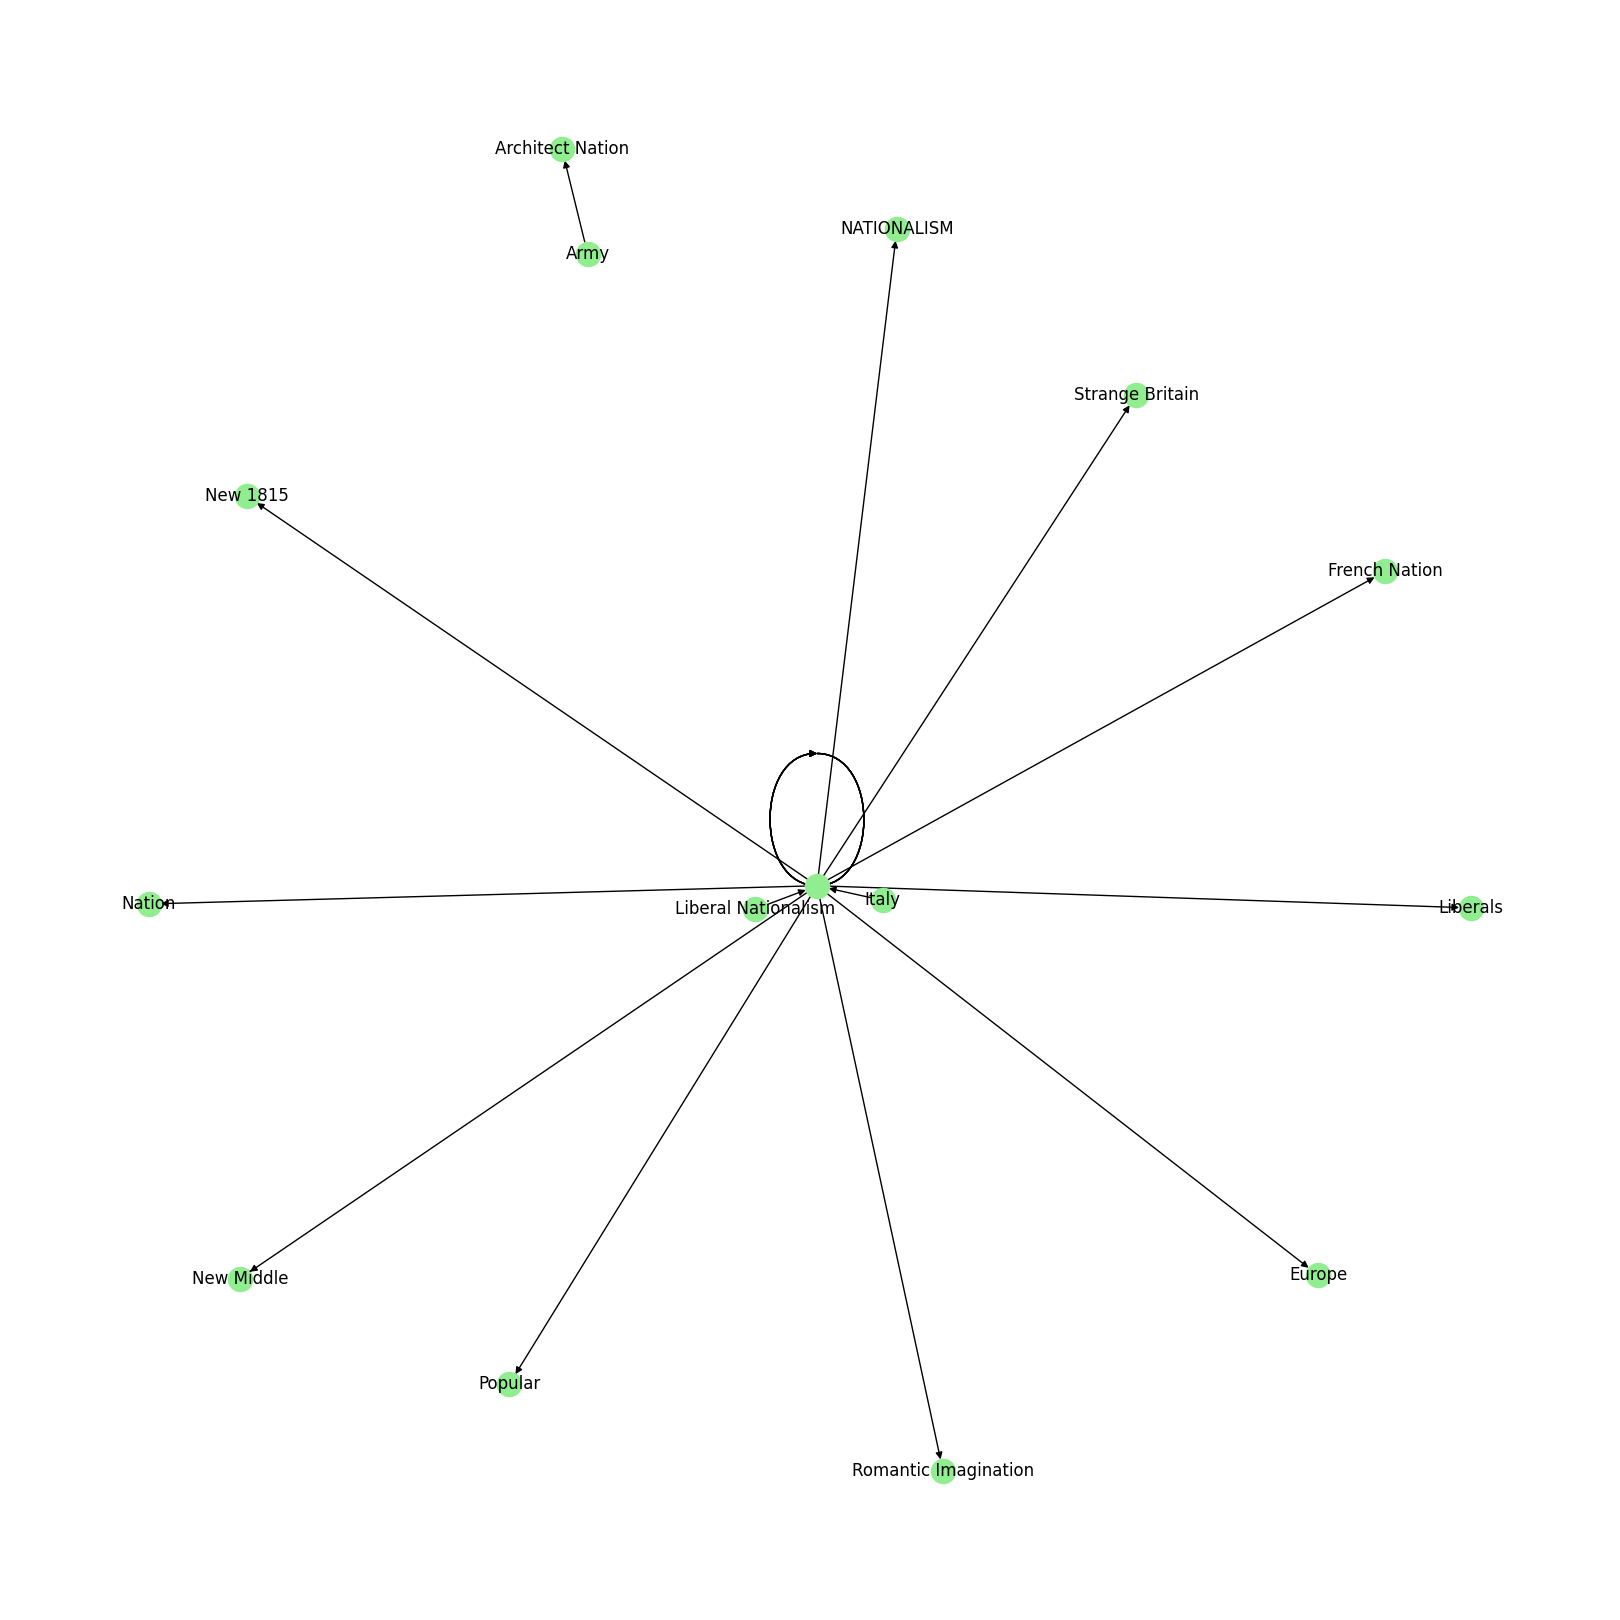

In [596]:
# Construct knowledge graph over extracted information (dataframe)
KG = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

# Plot Knowledge Graph
plt.figure(figsize=(16,16))
pos = nx.spring_layout(KG)
nx.draw(KG, with_labels=True, node_color='lightgreen', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


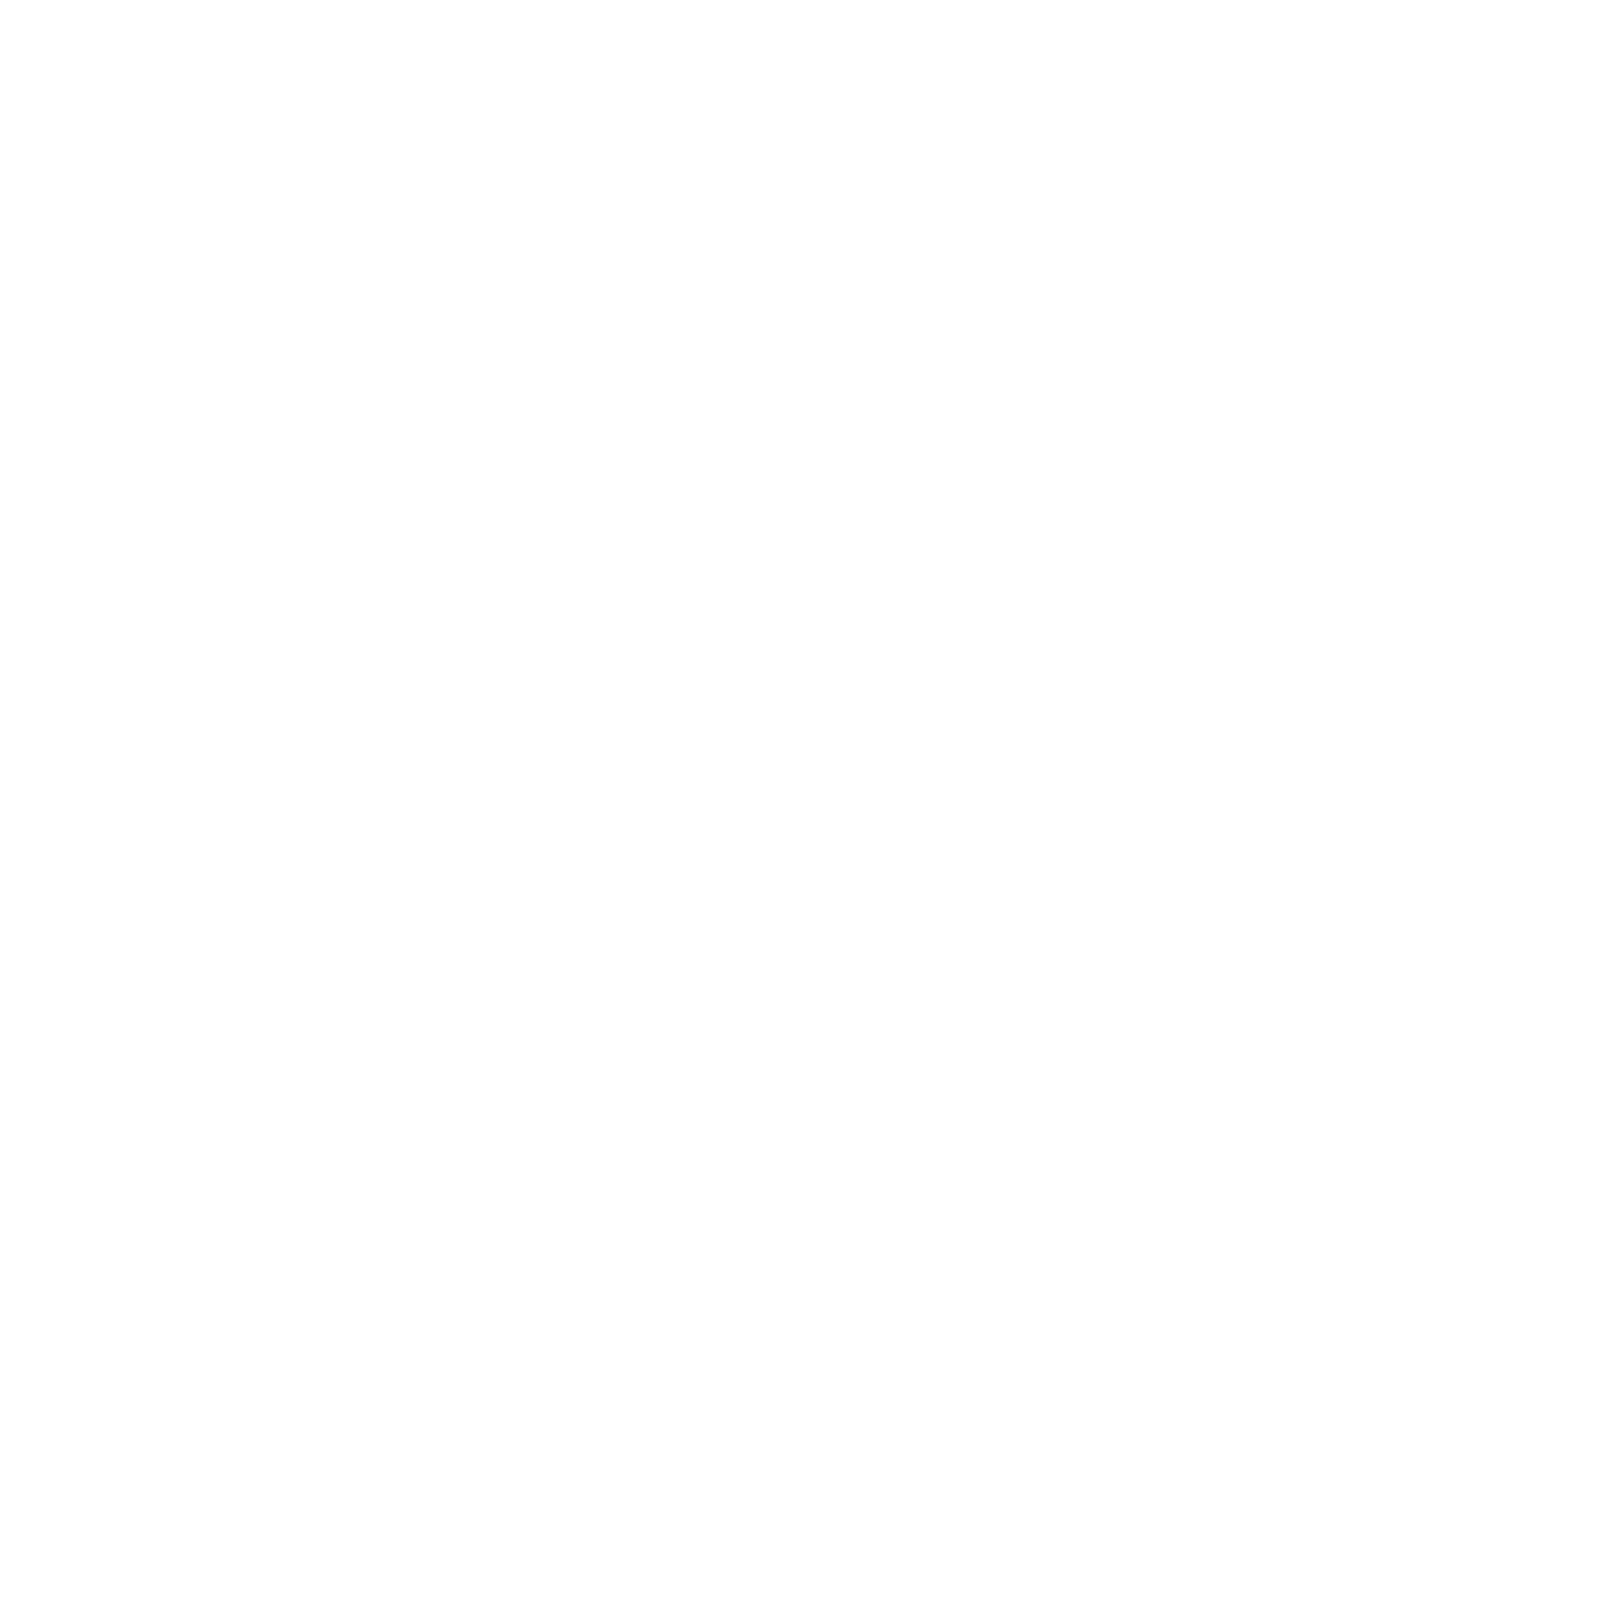

In [597]:
KG_rel = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="DESCRIPTION"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(16,16))
pos = nx.spring_layout(KG_rel, k = 3) # k regulates the distance between nodes
nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()